In [1]:
from __future__ import absolute_import
from __future__  import division
from __future__ import print_function
import tensorflow as tf
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import cv2
import numpy as np
import os
from PIL import Image
from io import BytesIO
import time

In [2]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import  Dropout, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [7]:
def souhaiel_model(tf,wgts='fightw.hdfs'):
    layers = tf.keras.layers
    models = tf.keras.models
    losses = tf.keras.losses
    optimizers = tf.keras.optimizers
    metrics = tf.keras.metrics
    num_classes = 2
    cnn = models.Sequential()
    #cnn.add(base_model)
    input_shapes=(160,160,3)
    np.random.seed(1234)
    vg19 = tf.keras.applications.vgg19.VGG19
    base_model = vg19(include_top=False,weights='imagenet',input_shape=(160, 160,3))
    # Freeze the layers except the last 4 layers (we will only use the base model to extract features)
    cnn = models.Sequential()
    cnn.add(base_model)
    cnn.add(layers.Flatten())
    model = models.Sequential()
    model.add(layers.TimeDistributed(cnn,  input_shape=(30, 160, 160, 3)))
    model.add(layers.LSTM(30 , return_sequences= True))
    model.add(layers.TimeDistributed(layers.Dense(90)))
    model.add(layers.Dropout(0.1))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation="sigmoid"))
    adam = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.load_weights(wgts)
    rms = optimizers.RMSprop()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])
    return model


In [8]:
model1 = souhaiel_model(tf)
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 12800)         20024384  
_________________________________________________________________
lstm (LSTM)                  (None, 30, 30)            1539720   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 90)            2790      
_________________________________________________________________
dropout (Dropout)            (None, 30, 90)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 90)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               46592     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

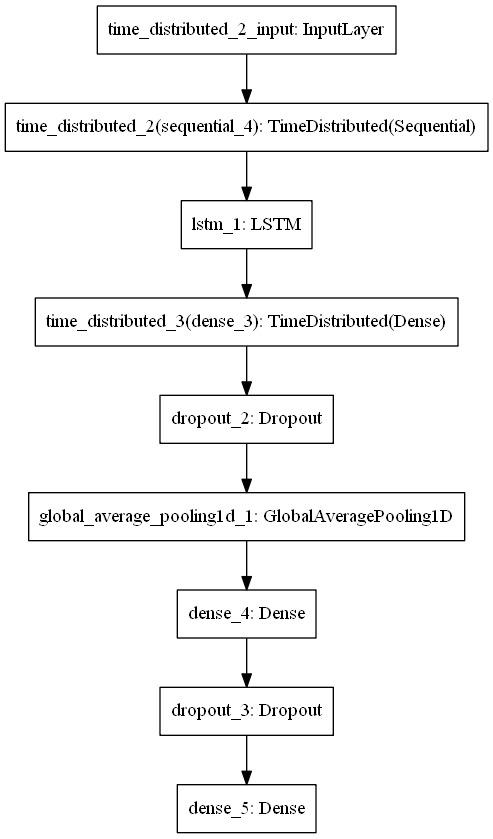

In [9]:
from tensorflow.keras.utils import plot_model
model1= souhaiel_model(tf)
plot_model(model1, to_file='souhaiel.png')

In [10]:
import numpy as np
from skimage.transform import resize
np.random.seed(1234)
model1 = souhaiel_model(tf)


In [12]:
graph = tf.compat.v1.get_default_graph

In [13]:
graph

<function tensorflow.python.framework.ops.get_default_graph()>

In [15]:
def video_reader(cv2,filename):
    frames = np.zeros((30, 160, 160, 3), dtype=np.float)
    i=0
    print(frames.shape)
    vc = cv2.VideoCapture(filename)
    if vc.isOpened():
        rval , frame = vc.read()
    else:
        rval = False
    frm = resize(frame,(160,160,3))
    frm = np.expand_dims(frm,axis=0)
    if(np.max(frm)>1):
        frm = frm/255.0
    frames[i][:] = frm
    i +=1
    print("reading video")
    while i < 30:
        rval, frame = vc.read()
        frm = resize(frame,(160,160,3))
        frm = np.expand_dims(frm,axis=0)
        if(np.max(frm)>1):
            frm = frm/255.0
        frames[i][:] = frm
        i +=1
    return frames

In [17]:
video_reader(cv2,'Blindinglights.mp4')

(30, 160, 160, 3)
reading video


array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [18]:
def pred_fight(model,video,acuracy=0.9):
    pred_test = model.predict(video)
    if pred_test[0][1] >=acuracy:
        return True , pred_test[0][1]
    else:
        return False , pred_test[0][1]

In [19]:
def main_fight(vidoss):
    vid = video_reader(cv2,vidoss)
    datav = np.zeros((1, 30, 160, 160, 3), dtype=np.float)
    datav[0][:][:] = vid
    millis = int(round(time.time() * 1000))
    print(millis)
    f , precent = pred_fight(model1,datav,acuracy=0.65)
    millis2 = int(round(time.time() * 1000))
    print(millis2)
    res_fight = {'violence':f ,'violenceestimation':str(precent)} 
    res_fight['processing_time'] =  str(millis2-millis)
    return res_fight

In [20]:
res = main_fight('Blindinglights.mp4')

(30, 160, 160, 3)
reading video
1605389543369
1605389589074


In [21]:
res

{'violence': False,
 'violenceestimation': '0.14153758',
 'processing_time': '45705'}

In [22]:
res = main_fight('fight.mp4')

(30, 160, 160, 3)
reading video
1605389617148
1605389649179


In [23]:
res

{'violence': True,
 'violenceestimation': '0.9834473',
 'processing_time': '32031'}